In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_json("7postElection.json")
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])

In [3]:
data["vaderScore"] = scores
data.drop(["in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","year","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,month,hour,week_year,labels,vaderScore
favorite_count,1.000000,0.760637,-0.114709,0.005212,-0.118400,0.182159,-0.046203
retweet_count,0.760637,1.000000,-0.092641,-0.035858,-0.095339,0.139384,-0.140966
month,-0.114709,-0.092641,1.000000,0.014660,0.982210,-0.035000,0.070478
hour,0.005212,-0.035858,0.014660,1.000000,0.008845,-0.022566,0.042642
week_year,-0.118400,-0.095339,0.982210,0.008845,1.000000,-0.036728,0.074418
labels,0.182159,0.139384,-0.035000,-0.022566,-0.036728,1.000000,-0.107722
vaderScore,-0.046203,-0.140966,0.070478,0.042642,0.074418,-0.107722,1.000000


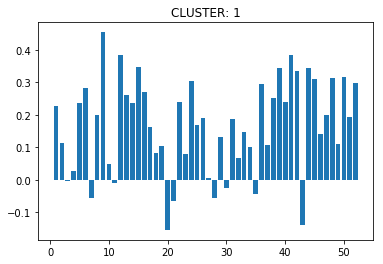

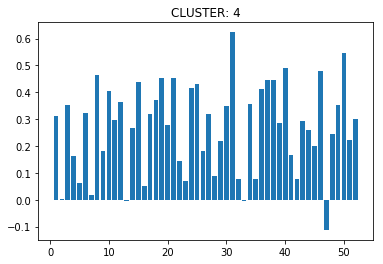

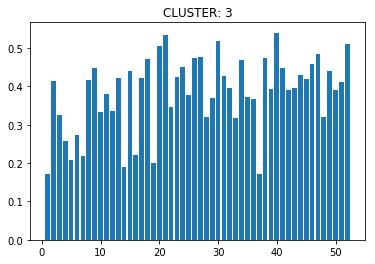

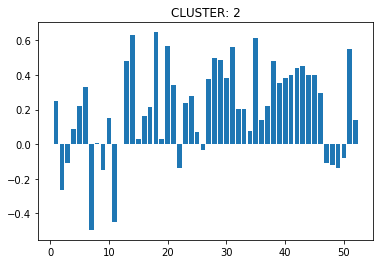

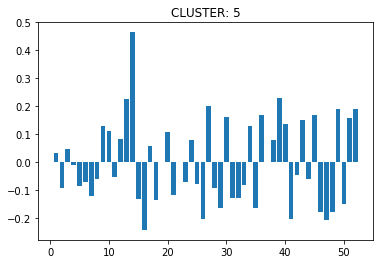

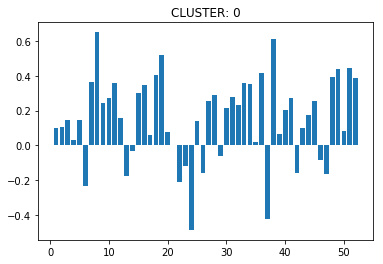

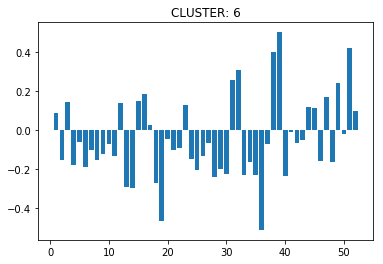

In [4]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()

In [5]:
x1 = data[data["labels"] == 6]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  

stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([2.924e+03, 7.100e+01, 2.000e+01, 1.200e+01, 3.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   4. ,  156.8,  309.6,  462.4,  615.2,  768. ,  920.8, 1073.6,
        1226.4, 1379.2, 1532. ]),
 <a list of 10 Patch objects>)

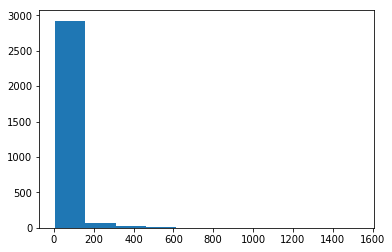

In [6]:
plt.hist(stemmed_words)

In [7]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!! sembra che il tempo peggiori sse e migliori silhouette
res1 = res.drop(["week_year","month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
#dataWithText = res.drop(["week_year","month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
dataWithText = res
res1.columns

Index(['vaderScore', '10', '100', '11', '116', '12', '12th', '13', '14', '15',
       ...
       'yearli', 'yesterday', 'yet', 'york', 'young', 'your', 'youth',
       'zealand', 'zero', 'zte'],
      dtype='object', length=1975)

# Hierarchical

In [ ]:
sil = []
for c in range(30,85):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(res1, 'average', "cosine")


In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()


In [10]:
#res1 = res.drop(["week_year","month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
#dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=100) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_

Index(['vaderScore', '10', '100', '11', '116', '12', '12th', '13', '14', '15',
       ...
       'yearli', 'yesterday', 'yet', 'york', 'young', 'your', 'youth',
       'zealand', 'zero', 'zte'],
      dtype='object', length=1975)


ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
d = silhouette_score(res1, labels,metric='cosine')
print(d)

In [ ]:
res1["labels"] = labels
dataWithText["labels"] = labels

g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        dictionary = corpora.Dictionary(corp)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
        tfidf = TfidfModel(doc_term_matrix)
        tfidf_corpus = tfidf[doc_term_matrix]

        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)
        words = 7
        lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
        #print(lsamodel.show_topics(num_topics = -1,num_words = words))

        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()
        
        
        #piechart
        topics = lsamodel.show_topics(num_topics=-1, num_words=10, log=True, formatted=False)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.05:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            #manca il pie o la rappresentazione
            sns.barplot(x=weights, y=words)
            plt.show()

# kmeans

In [ ]:
%%time
sse_list = list()
max_k = 40
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(res1)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()

In [11]:
#i cluster sembrano suddividere in settimane consecutive 

true_k =7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(res1)
print(model.inertia_)
print
labels = model.labels_
res1["labels"] = labels
dataWithText["labels"] = labels
d = silhouette_score(res1, labels,metric='euclidean')
print(d)

701.7562514417284
0.22667643773659285


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  6  lunghezza  120
NUMBER OF TOPICS FOR CLUSTER  6  :  1


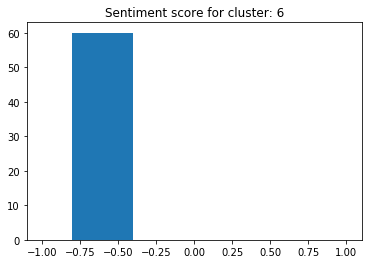

[1, 2, 4, 8, 11, 12, 16, 18, 22, 24, 25, 26, 30, 33, 34, 37, 41, 44, 46, 47, 48, 51, 52, 5, 6, 10, 14, 17, 19, 20, 21, 23, 27, 28, 29, 32, 36, 39, 42, 43, 45, 49, 50, 3, 9]


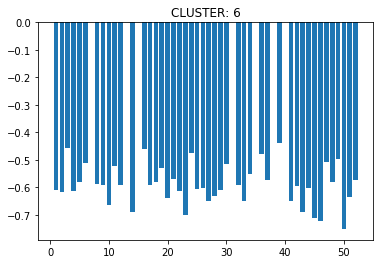

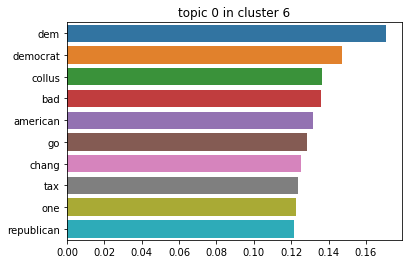

cluster  0  lunghezza  101
NUMBER OF TOPICS FOR CLUSTER  0  :  3


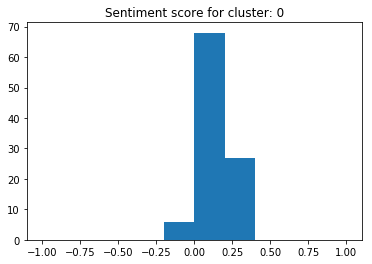

[1, 2, 4, 5, 6, 7, 8, 17, 18, 23, 24, 25, 26, 28, 29, 30, 33, 35, 36, 39, 41, 42, 43, 44, 45, 46, 3, 11, 15, 19, 20, 22, 31, 32, 37, 47, 48, 51, 52, 10]


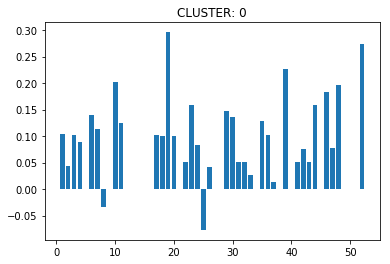

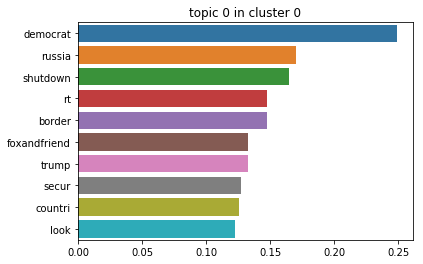

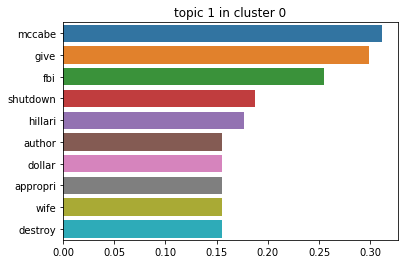

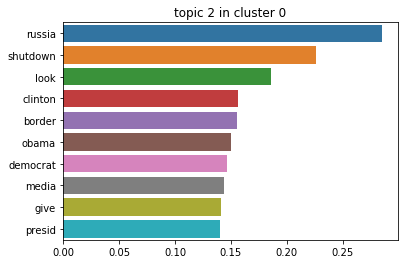

cluster  2  lunghezza  60
NUMBER OF TOPICS FOR CLUSTER  2  :  3


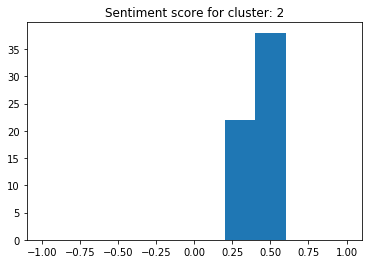

[1, 10, 12, 14, 17, 20, 23, 25, 27, 28, 29, 31, 32, 38, 46, 52, 2, 3, 5, 6, 8, 11, 16, 19, 21, 34, 37, 39, 43, 47, 49, 50, 4]


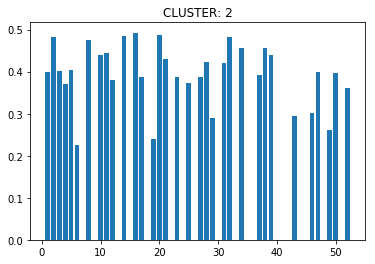

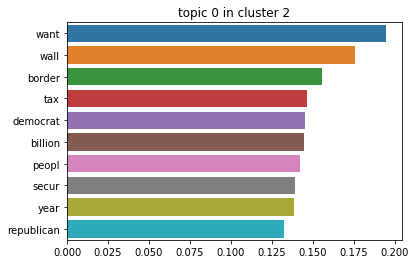

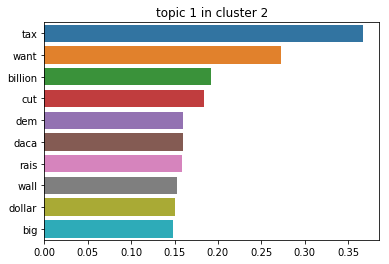

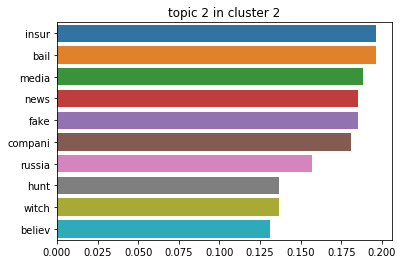

cluster  3  lunghezza  101
NUMBER OF TOPICS FOR CLUSTER  3  :  4


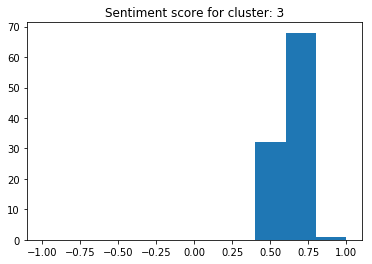

[1, 2, 9, 10, 16, 17, 25, 30, 32, 34, 39, 40, 41, 42, 48, 51, 3, 4, 5, 6, 7, 8, 12, 14, 15, 20, 21, 22, 23, 24, 26, 27, 29, 31, 33, 37, 38, 43, 44, 45, 47, 52, 11]


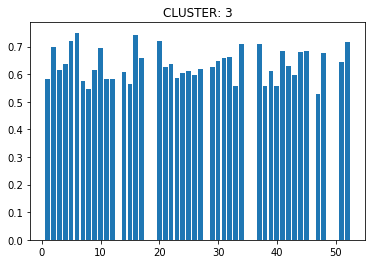

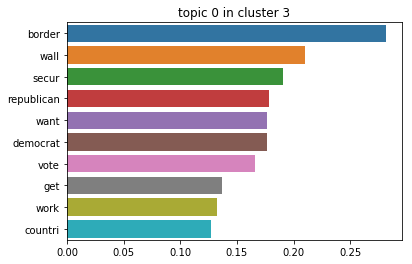

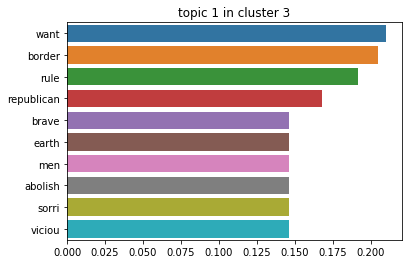

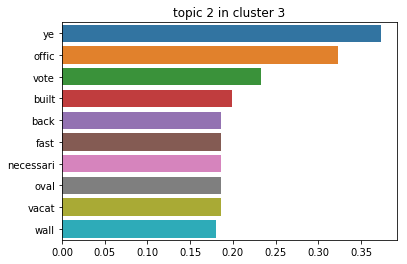

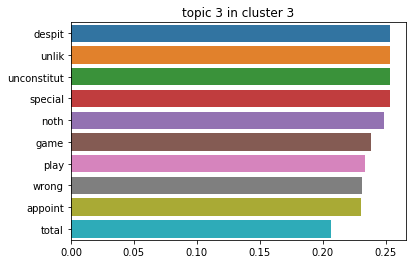

cluster  4  lunghezza  100
NUMBER OF TOPICS FOR CLUSTER  4  :  4


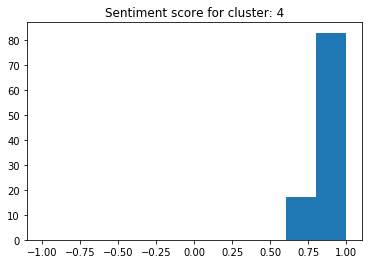

[1, 5, 6, 7, 11, 12, 15, 33, 35, 39, 41, 43, 44, 45, 46, 47, 50, 51, 52, 3, 8, 10, 13, 16, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 34, 37, 38, 48, 49, 2, 9]


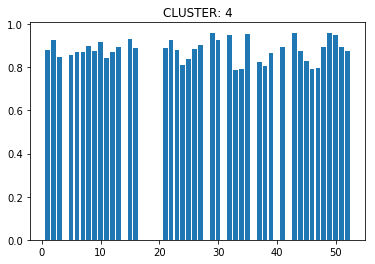

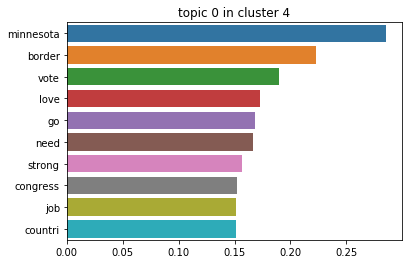

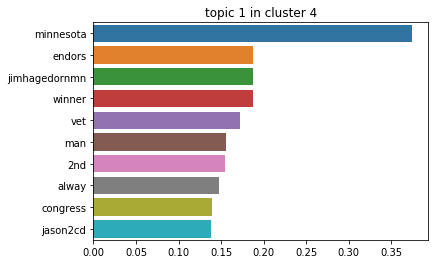

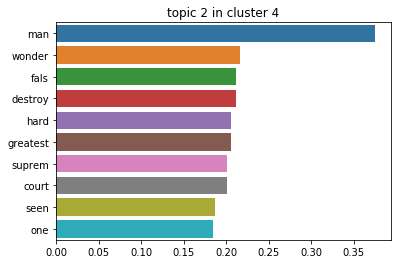

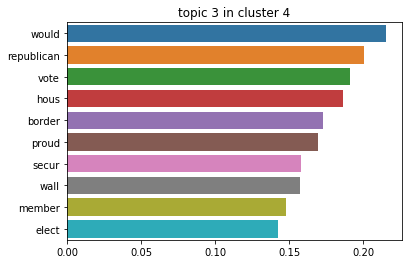

cluster  1  lunghezza  144
NUMBER OF TOPICS FOR CLUSTER  1  :  1


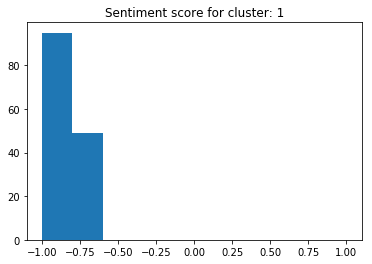

[2, 4, 5, 6, 7, 8, 9, 10, 13, 16, 17, 19, 37, 41, 42, 43, 44, 47, 48, 3, 14, 15, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 40, 45, 46, 50, 51, 52, 1, 11, 12]


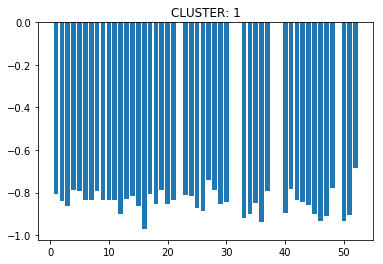

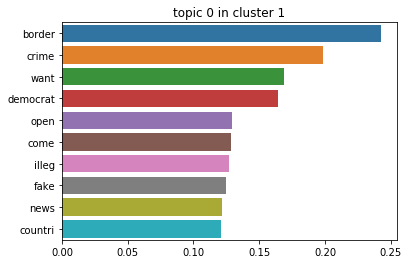

cluster  5  lunghezza  100
NUMBER OF TOPICS FOR CLUSTER  5  :  2


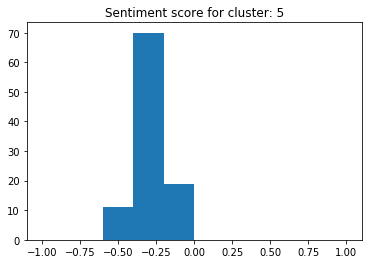

[3, 7, 9, 13, 22, 23, 26, 28, 29, 30, 34, 37, 38, 39, 40, 41, 42, 44, 48, 50, 52, 2, 4, 8, 14, 15, 16, 18, 20, 24, 25, 27, 31, 32, 35, 43, 45, 46, 47, 51, 1, 5, 6, 10, 11]


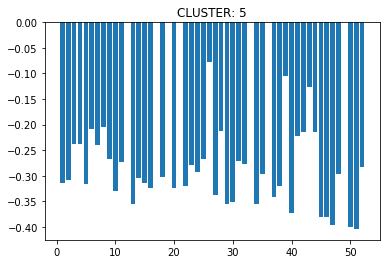

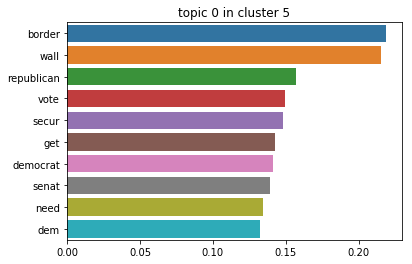

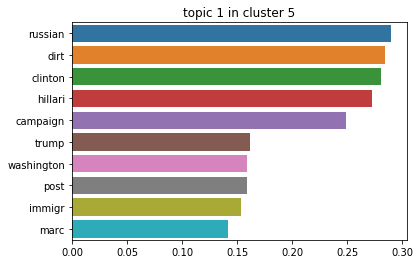

In [13]:
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        dictionary = corpora.Dictionary(corp)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
        tfidf = TfidfModel(doc_term_matrix)
        tfidf_corpus = tfidf[doc_term_matrix]

        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)
        words = 7
        lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
        #print(lsamodel.show_topics(num_topics = -1,num_words = words))

        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        
        print(d1["week_year"].unique().tolist())
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()

        
        #piechart
        topics = lsamodel.show_topics(num_topics=-1, num_words=10, log=True, formatted=False)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.05:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            #manca il pie o la rappresentazione
            sns.barplot(x=weights, y=words)
            plt.show()